In [49]:
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.6 MB/s 
     |████████████████████████████████| 831.4 MB 14 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [4]:
! pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 118 kB 4.6 MB/s 


In [5]:
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
import matplotlib.pyplot as plt
import sacrebleu

In [6]:
SRC_LANGUAGE = 'de' # for code
TGT_LANGUAGE = 'en' # for comments

# Place-holders
token_transform = {}
vocab_transform = {}

In [7]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [8]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab

special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [9]:
Train_data = pd.read_csv("/content/drive/MyDrive/python_dataset.csv")
Test_data = pd.read_excel("/content/drive/MyDrive/python_test_dataset.xlsx")

In [10]:
Train_data = Train_data[:10000] # taking only 10000 rows from approximately 600000 rows, cause then it will take too long to train

In [11]:
Train_data.head()

,Unnamed: 0,code,docstring
0,0,"sorted(l, key=lambda x: (-int(x[1]), x[0]))",Sort a nested list by two elements
1,1,[int(x) for x in str(num)],converting integer to list in python
2,2,c.decode('unicode_escape'),Converting byte string in unicode string
3,3,"parser.add_argument('-t', dest='table', help='...",List of arguments with argparse
4,4,"datetime.datetime.strptime(s, '%Y-%m-%dT%H:%M:...",How to convert a Date string to a DateTime obj...


In [12]:
Train_code = Train_data['code'].to_numpy()
Train_comment = Train_data['docstring'].to_numpy()
Train_code_comment = []

Test_code = Test_data['code'].to_numpy()
Test_comment = Test_data['docstring'].to_numpy()
Test_code_comment = []

In [13]:
for i in range(len(Train_code)):
    Train_code[i] = str(Train_code[i])
    Train_comment[i] = str(Train_comment[i])

for i in range(len(Test_code)):
    Test_code[i] = str(Test_code[i])
    Test_comment[i] = str(Test_comment[i])

In [14]:
for i in range(len(Train_code)):
    Train_code_comment.append((Train_code[i], Train_comment[i]))

for i in range(len(Test_code)):
    Test_code_comment.append((Test_code[i], Test_comment[i]))

In [ ]:
# Train_iterator = iter(Train_code_comment)
# Test_iterator = iter(Test_code_comment)

In [15]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Train_code_comment

    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=2,
                                                    specials=special_symbols,
                                                    special_first=True)

In [16]:
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [17]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [18]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [19]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 16
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [20]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [21]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Train_code_comment
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Test_code_comment
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [22]:
train_loss_list = []
val_loss_list = []

from timeit import default_timer as timer
NUM_EPOCHS = 50

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_loss_list.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_list.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    # print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Epoch: 1, Train loss: 4.678, Val loss: 4.145, Epoch time = 16.071s
Epoch: 2, Train loss: 3.894, Val loss: 3.722, Epoch time = 15.928s
Epoch: 3, Train loss: 3.583, Val loss: 3.495, Epoch time = 16.033s
Epoch: 4, Train loss: 3.359, Val loss: 3.273, Epoch time = 16.204s
Epoch: 5, Train loss: 3.165, Val loss: 3.071, Epoch time = 17.280s
Epoch: 6, Train loss: 2.987, Val loss: 2.876, Epoch time = 16.215s
Epoch: 7, Train loss: 2.820, Val loss: 2.724, Epoch time = 16.129s
Epoch: 8, Train loss: 2.663, Val loss: 2.555, Epoch time = 16.178s
Epoch: 9, Train loss: 2.508, Val loss: 2.426, Epoch time = 16.139s
Epoch: 10, Train loss: 2.362, Val loss: 2.263, Epoch time = 16.133s
Epoch: 11, Train loss: 2.222, Val loss: 2.122, Epoch time = 16.136s
Epoch: 12, Train loss: 2.090, Val loss: 1.977, Epoch time = 16.188s
Epoch: 13, Train loss: 1.964, Val loss: 1.835, Epoch time = 16.192s
Epoch: 14, Train loss: 1.838, Val loss: 1.741, Epoch time = 16.335s
Epoch: 15, Train loss: 1.722, Val loss: 1.634, Epoch time

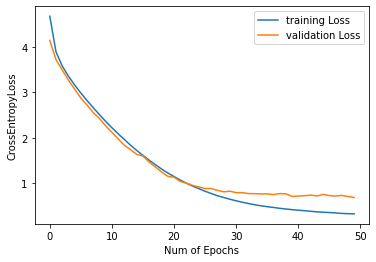

In [46]:
x_axis = [i for i in range(NUM_EPOCHS)]
plt.plot(x_axis, train_loss_list, label="training Loss")
plt.plot(x_axis, val_loss_list, label="validation Loss")
plt.xlabel("Num of Epochs")
plt.ylabel("CrossEntropyLoss")
plt.legend()
plt.show()

In [24]:
print(translate(transformer, "[int(x) for x in str(num)]"))

 converting integer to list in python 


In [42]:
print(translate(transformer, "if (num % i) == 0:"))

 How to perform if one of the same zero ? 


In [36]:
print(translate(transformer, Test_code_comment[11][0]))
print(Test_code_comment[11][1])

 Python splitting string by parentheses 
Python splitting string by parentheses


In [47]:
total_bleu_score = 0
diff = 0
for i in range(len(Test_code_comment)):
    pred = translate(transformer, Test_code_comment[i][0])
    bleu_score = (sacrebleu.sentence_bleu(pred, [Test_code_comment[i][1]], smooth_method='exp')).score
    print(bleu_score)
    total_bleu_score += bleu_score
    # if(bleu_score==0):
    #     diff += 1

100.00000000000004
100.00000000000004
100.00000000000004
21.200626759025184
100.00000000000004
71.02992180127417
23.462350320528007
0.0
100.00000000000004
76.26264731696685
45.180100180492246
100.00000000000004
87.0239763769791
100.00000000000004
5.815868174415823
86.6877899750182
100.00000000000004
100.00000000000004
73.61703354503862
100.00000000000004
100.00000000000004
100.00000000000004
100.00000000000004
13.485111859503691
5.693025330278465
81.93228857188173
81.93228857188173
81.93228857188173
100.00000000000004
8.170609724417774
100.00000000000004
100.00000000000004
100.00000000000004
100.00000000000004
100.00000000000004
100.00000000000004
75.77395672414198
6.722636787666482
33.18077402843942
61.62607099729587
100.00000000000004
4.767707020457095
100.00000000000004
100.00000000000004
100.00000000000004
100.00000000000004
3.7477767366779213
0.0
0.0
4.196114906296549
4.8734989388136185
4.79981069911921
0.0
0.0
100.00000000000004
100.00000000000004
100.00000000000004
100.000000000

In [48]:
print(f"Total test bleu score = {total_bleu_score/(len(Test_code_comment)-diff):.4f}")

Total test bleu score = 62.5760
